In [1]:
# !pip install boto3 s3fs pandas nibabel matplotlib


In [23]:
# ===============================
# Public S3 multimodal exploration
# ===============================

import boto3
from botocore import UNSIGNED
from botocore.client import Config
import s3fs
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os




In [24]:
# -------------------------------
# S3 configuration (anonymous)
# -------------------------------
BUCKET = "chimera-challenge"
PREFIX = "v2/task3/"

s3 = boto3.client(
    "s3",
    config=Config(signature_version=UNSIGNED)
)

fs = s3fs.S3FileSystem(anon=True)



In [25]:
# -------------------------------
# Utilities
# -------------------------------
def list_objects(bucket, prefix, max_items=50):
    paginator = s3.get_paginator("list_objects_v2")
    keys = []
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            keys.append(obj["Key"])
            if len(keys) >= max_items:
                return keys
    return keys

def list_folders(bucket, prefix):
    response = s3.list_objects_v2(
        Bucket=bucket,
        Prefix=prefix,
        Delimiter="/"
    )
    return [p["Prefix"] for p in response.get("CommonPrefixes", [])]

def read_csv_from_s3(bucket, key):
    obj = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(obj["Body"])

def load_nifti_from_s3(s3_path):
    with fs.open(s3_path, "rb") as f:
        return nib.load(f)

def show_middle_slice(volume, title=None, cmap="gray"):
    z = volume.shape[2] // 2
    plt.imshow(volume[:, :, z], cmap=cmap)
    if title:
        plt.title(title)
    plt.axis("off")



In [26]:
# -------------------------------
# Explore dataset structure
# -------------------------------
print("Top-level folders:")
display(pd.DataFrame(list_folders(BUCKET, PREFIX), columns=["Folder"]))

print("Sample files:")
display(pd.DataFrame(list_objects(BUCKET, PREFIX, max_items=25), columns=["S3 Key"]))


Top-level folders:


,Folder
0,v2/task3/data/
1,v2/task3/features/


Sample files:


,S3 Key
0,v2/task3/data/3A_001/3A_001_CD.json
1,v2/task3/data/3A_001/3A_001_HE.tif
2,v2/task3/data/3A_001/3A_001_HE_mask.tif
3,v2/task3/data/3A_001/3A_001_RNA.json
4,v2/task3/data/3A_002/3A_002_CD.json
5,v2/task3/data/3A_002/3A_002_HE.tif
6,v2/task3/data/3A_002/3A_002_HE_mask.tif
7,v2/task3/data/3A_002/3A_002_RNA.json
8,v2/task3/data/3A_003/3A_003_CD.json
9,v2/task3/data/3A_003/3A_003_HE.tif


In [27]:
FEATURES_PREFIX = "v2/task3/features/"

print("Contents of features/:")
display(pd.DataFrame(
    list_objects(BUCKET, FEATURES_PREFIX, max_items=100),
    columns=["S3 Key"]
))


Contents of features/:


,S3 Key
0,v2/task3/features/coordinates/3A_001_HE.npy
1,v2/task3/features/coordinates/3A_002_HE.npy
2,v2/task3/features/coordinates/3A_003_HE.npy
3,v2/task3/features/coordinates/3A_004_HE.npy
4,v2/task3/features/coordinates/3A_005_HE.npy
...,...
95,v2/task3/features/coordinates/3A_129_HE.npy
96,v2/task3/features/coordinates/3A_130_HE.npy
97,v2/task3/features/coordinates/3A_134_HE.npy
98,v2/task3/features/coordinates/3A_135_HE.npy


In [28]:


npy_key = "v2/task3/features/coordinates/3A_001_HE.npy"

with fs.open(f"s3://{BUCKET}/{npy_key}", "rb") as f:
    npy = np.load(f)

print("Arrays inside NPY:")
print(npy)

# print("Example array shape:")
# print(npy[npy.files[0]].shape)

Arrays inside NPY:
[(165632, 121600, 224, 0, 1., 230, 0.25)
 (165632, 121824, 224, 0, 1., 230, 0.25)
 (165632, 122048, 224, 0, 1., 230, 0.25) ...
 (263264, 180768, 224, 0, 1., 230, 0.25)
 (263264, 180992, 224, 0, 1., 230, 0.25)
 (263264, 181216, 224, 0, 1., 230, 0.25)]


In [29]:
# -------------------------------
# Storing and Exploring Metadata
# -------------------------------

# Path to the QC file
qc_key = "v2/task3/data/task3_quality_control.csv"

# Read CSV directly from S3
df_qc = read_csv_from_s3(BUCKET, qc_key)

# Display basic info
display(df_qc.head())
print("Shape:", df_qc.shape)
print("\nColumns:")
print(df_qc.columns.tolist())

# Define output path
output_dir = "../data/chimera"
output_path = os.path.join(output_dir, "metadata.csv")

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save QC metadata
df_qc.to_csv(output_path, index=False)

print(f"Saved metadata to: {output_path}")
print("Shape:", df_qc.shape)


,chimera_id_t3,cohort,tumor_type,wsi_quality,holes,tumor
0,3A_001,A,Primary,Good,Yes,Yes
1,3A_002,A,Primary,Good,No,Yes
2,3A_003,A,Primary,Good,No,Yes
3,3A_004,A,Primary,Good,Yes,Yes
4,3A_005,A,Primary,Good,Yes,Yes


Shape: (176, 6)

Columns:
['chimera_id_t3', 'cohort', 'tumor_type', 'wsi_quality', 'holes', 'tumor']
Saved metadata to: ../data/chimera/metadata.csv
Shape: (176, 6)


In [16]:
summary = []

for col in df_qc.columns:
    vc = df_qc[col].value_counts(dropna=False)
    summary.append({
        "column": col,
        "n_unique": df_qc[col].nunique(dropna=True),
        "n_missing": df_qc[col].isna().sum(),
        "top_5_values_and_counts": vc.head(5).to_dict()
    })

summary_df = pd.DataFrame(summary)
display(summary_df)


,column,n_unique,n_missing,top_5_values_and_counts
0,chimera_id_t3,176,0,"{'3A_001': 1, '3A_002': 1, '3A_149': 1, '3A_15..."
1,cohort,2,0,"{'A': 126, 'B': 50}"
2,tumor_type,1,0,{'Primary': 176}
3,wsi_quality,2,0,"{'Good': 163, 'Poor': 13}"
4,holes,2,0,"{'Yes': 127, 'No': 49}"
5,tumor,2,0,"{'Yes': 175, 'No': 1}"


In [30]:
df_qc.describe(include="all")
df_qc["status"].value_counts() if "status" in df_qc.columns else None


In [31]:
# -------------------------------
# Storing and exploring clicnical data
# -------------------------------
# 
# # Inspect patient IDs
# display(df_qc.head())

# Assume there's a column like 'patient_id' (adjust if needed)
patient_id = df_qc.iloc[0]["chimera_id_t3"]
print("Using patient_id:", patient_id)


Using patient_id: 3A_001


In [32]:
json_key = f"v2/task3/data/{patient_id}/{patient_id}_CD.json"
print("JSON key:", json_key)

import json

obj = s3.get_object(Bucket=BUCKET, Key=json_key)
json_data = json.load(obj["Body"])

# Inspect contents
type(json_data), list(json_data.keys())

JSON key: v2/task3/data/3A_001/3A_001_CD.json


(dict,
 ['age',
  'sex',
  'smoking',
  'tumor',
  'stage',
  'substage',
  'grade',
  'reTUR',
  'LVI',
  'variant',
  'EORTC',
  'no_instillations',
  'BRS',
  'progression',
  'Time_to_prog_or_FUend'])

In [33]:
df_json = pd.json_normalize(json_data)
display(df_json.head())


,age,sex,smoking,tumor,stage,substage,grade,reTUR,LVI,variant,EORTC,no_instillations,BRS,progression,Time_to_prog_or_FUend
0,72,Male,No,Primary,T1HG,T1m,G3,Yes,No,UCC,Highest risk,24.0,BRS2,0,110


In [34]:
import json
from tqdm import tqdm

records = []

for pid in tqdm(df_qc["chimera_id_t3"].dropna().unique()):
    json_key = f"v2/task3/data/{pid}/{pid}_CD.json"
    
    try:
        obj = s3.get_object(Bucket=BUCKET, Key=json_key)
        data = json.load(obj["Body"])
        
        # Flatten JSON (handles nested fields safely)
        flat = pd.json_normalize(data)
        flat["chimera_id_t3"] = pid
        
        records.append(flat)
        
    except s3.exceptions.NoSuchKey:
        print(f"Missing JSON for {pid}")
    except Exception as e:
        print(f"Error reading {pid}: {e}")

# Combine all patients into one DataFrame
df_json_all = pd.concat(records, ignore_index=True)

display(df_json_all.head())
print("Shape:", df_json_all.shape)


100%|██████████| 176/176 [00:20<00:00,  8.73it/s]


,age,sex,smoking,tumor,stage,substage,grade,reTUR,LVI,variant,EORTC,no_instillations,BRS,progression,Time_to_prog_or_FUend,chimera_id_t3
0,72,Male,No,Primary,T1HG,T1m,G3,Yes,No,UCC,Highest risk,24.0,BRS2,0,110,3A_001
1,59,Male,No,Primary,T1HG,T1e,G3,Yes,No,UCC,High risk,27.0,BRS3,0,126,3A_002
2,73,Male,Yes,Primary,T1HG,T1e,G3,No,No,UCC,Highest risk,15.0,BRS2,1,18,3A_003
3,63,Female,No,Primary,T1HG,T1e,G3,No,No,UCC,High risk,27.0,BRS2,0,155,3A_004
4,66,Male,Yes,Primary,T1HG,T1m,G3,Yes,No,UCC,Highest risk,6.0,BRS1,0,34,3A_005


Shape: (176, 16)


In [22]:
summary = []

for col in df_json_all.columns:
    vc = df_json_all[col].value_counts(dropna=False)
    summary.append({
        "column": col,
        "n_unique": df_json_all[col].nunique(dropna=True),
        "n_missing": df_json_all[col].isna().sum(),
        "top_5_values_and_counts": vc.head(5).to_dict()
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

,column,n_unique,n_missing,top_5_values_and_counts
0,age,41,0,"{65: 11, 69: 10, 70: 9, 77: 9, 73: 8}"
1,sex,2,0,"{'Male': 147, 'Female': 29}"
2,smoking,3,0,"{'Yes': 97, 'No': 63, '-1': 16}"
3,tumor,1,0,{'Primary': 176}
4,stage,2,0,"{'T1HG': 164, 'TaHG': 12}"
5,substage,3,0,"{'T1e': 124, 'T1m': 40, '-1': 12}"
6,grade,2,0,"{'G3': 169, 'G2': 7}"
7,reTUR,2,0,"{'Yes': 114, 'No': 62}"
8,LVI,3,0,"{'No': 157, '-1': 12, 'Yes': 7}"
9,variant,2,0,"{'UCC': 152, 'UCC + Variant': 24}"


In [15]:

# Define output path
output_dir = "../data/chimera"
output_path = os.path.join(output_dir, "clinical_data.csv")

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save DataFrame
df_json_all.to_csv(output_path, index=False)

print(f"Saved clinical data to: {output_path}")
print("Shape:", df_json_all.shape)

Saved clinical data to: ../data/chimera/clinical_data.csv
Shape: (176, 16)


In [16]:
# pip install imagecodecs

In [5]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np

def show_wsi_thumbnail(s3_path, title=None):
    try:
        import imagecodecs
    except ImportError:
        print("Error: 'imagecodecs' is not installed. Please run 'pip install imagecodecs'.")
        return

    with fs.open(s3_path, "rb") as f:
        with tifffile.TiffFile(f) as tif:
            # We target the last page, which is usually the smallest thumbnail
            # This avoids loading gigabytes of data into your RAM
            level_idx = len(tif.pages) - 1
            thumbnail = tif.pages[level_idx].asarray()
            
            plt.figure(figsize=(8, 8))
            plt.imshow(thumbnail)
            
            # Display metadata info
            mpp = tif.pages[0].tags.get('XResolution') # Often contains microns per pixel
            plt.title(f"{title if title else s3_path.split('/')[-1]}\nLevel: {level_idx} | Shape: {thumbnail.shape}")
            plt.axis("off")
            plt.show()

# Example:
# show_wsi_thumbnail_safe(f"s3://{BUCKET}/{PREFIX}data/3A_001/3A_001_HE.tif")

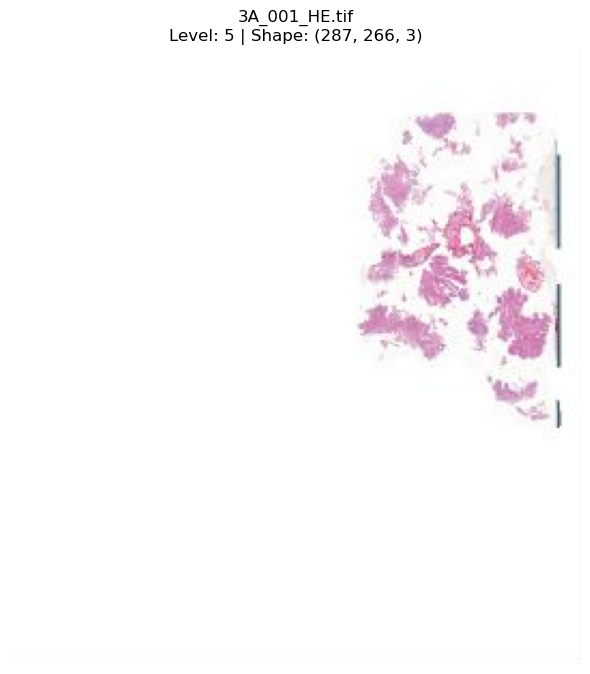

In [18]:
# Example Usage:
patient_id = "3A_001"
s3_wsi_path = f"s3://{BUCKET}/{PREFIX}data/{patient_id}/{patient_id}_HE.tif"
show_wsi_thumbnail(s3_wsi_path)

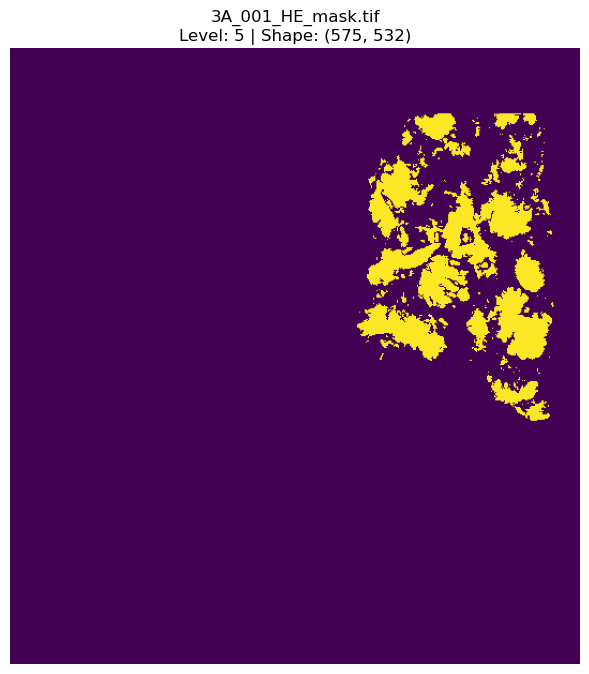

In [6]:
# Example Usage:
patient_id = "3A_001"
s3_wsi_path = f"s3://{BUCKET}/{PREFIX}data/{patient_id}/{patient_id}_HE_mask.tif"
show_wsi_thumbnail(s3_wsi_path)

In [35]:
# merging and plotting 

In [36]:
# Merge df_json and df_qc on 'chimera_id_t3'
df_merged = pd.merge(df_json_all, df_qc, on="chimera_id_t3", how="inner")

# Inspect
display(df_merged.head())
print("Merged shape:", df_merged.shape)

,age,sex,smoking,tumor_x,stage,substage,grade,reTUR,LVI,variant,...,no_instillations,BRS,progression,Time_to_prog_or_FUend,chimera_id_t3,cohort,tumor_type,wsi_quality,holes,tumor_y
0,72,Male,No,Primary,T1HG,T1m,G3,Yes,No,UCC,...,24.0,BRS2,0,110,3A_001,A,Primary,Good,Yes,Yes
1,59,Male,No,Primary,T1HG,T1e,G3,Yes,No,UCC,...,27.0,BRS3,0,126,3A_002,A,Primary,Good,No,Yes
2,73,Male,Yes,Primary,T1HG,T1e,G3,No,No,UCC,...,15.0,BRS2,1,18,3A_003,A,Primary,Good,No,Yes
3,63,Female,No,Primary,T1HG,T1e,G3,No,No,UCC,...,27.0,BRS2,0,155,3A_004,A,Primary,Good,Yes,Yes
4,66,Male,Yes,Primary,T1HG,T1m,G3,Yes,No,UCC,...,6.0,BRS1,0,34,3A_005,A,Primary,Good,Yes,Yes


Merged shape: (176, 21)


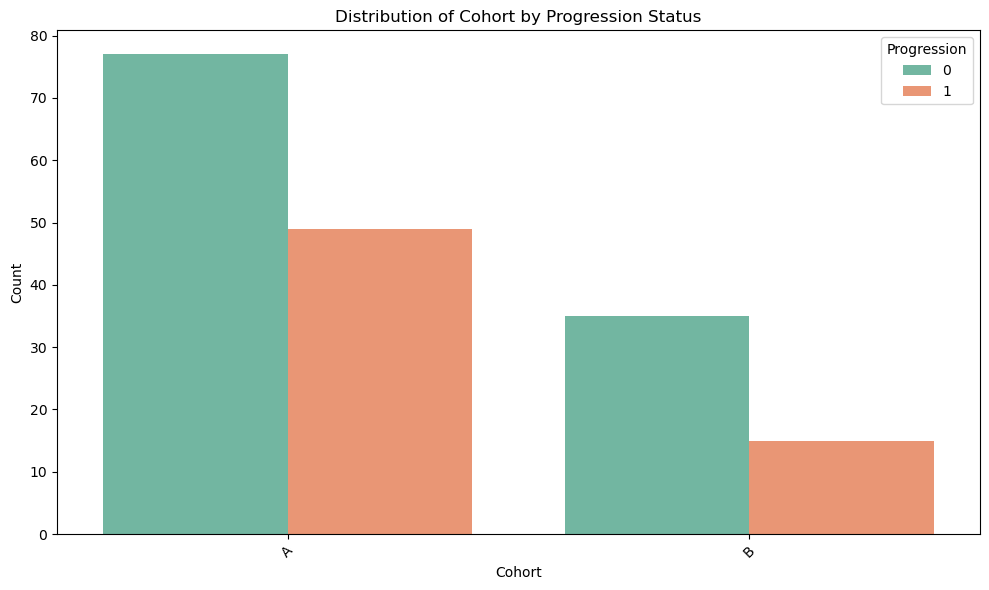

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example columns: 'cohort', 'progression' in df_merged
plt.figure(figsize=(10,6))
sns.countplot(
    data=df_merged,
    x='cohort',
    hue='progression',   # separates bars by progression status
    palette='Set2'
)

plt.title('Distribution of Cohort by Progression Status')
plt.xlabel('Cohort')
plt.ylabel('Count')
plt.legend(title='Progression')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/zl/l0prjwwn0db0fm9nhs69bxgh0000gn/T/ipykernel_47878/226588127.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='cohort', y=col, palette='Set2')


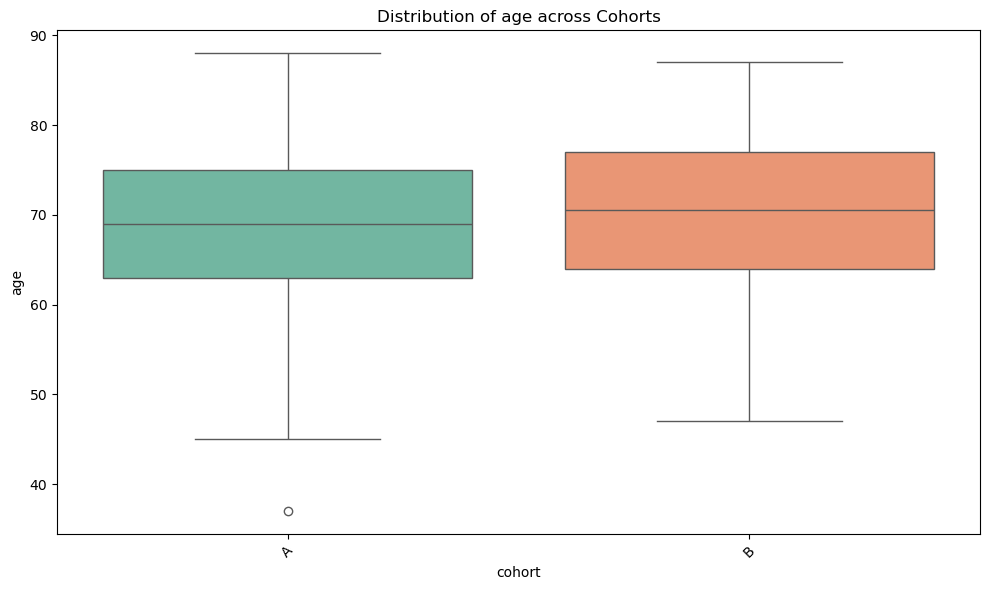

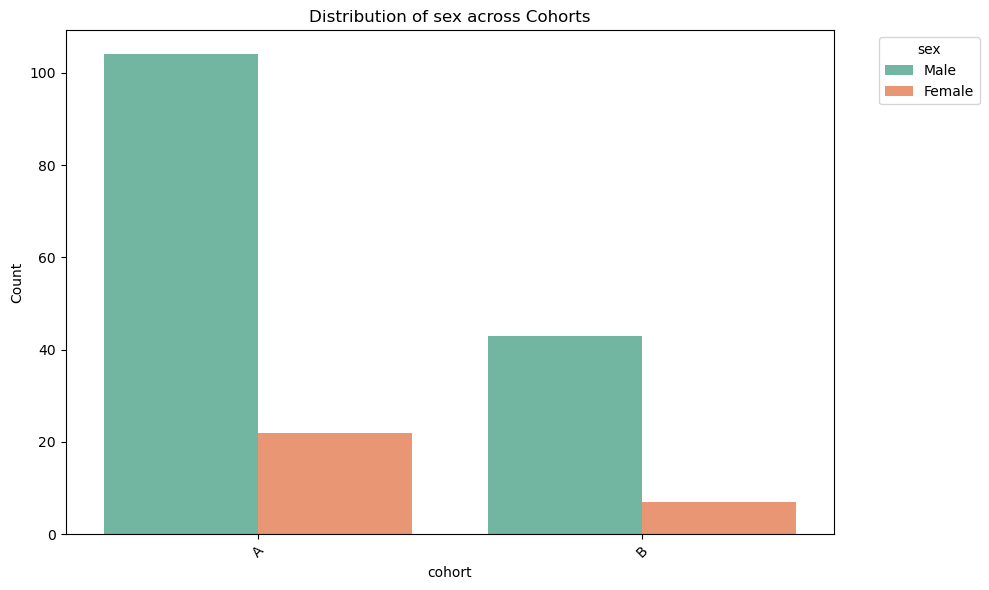

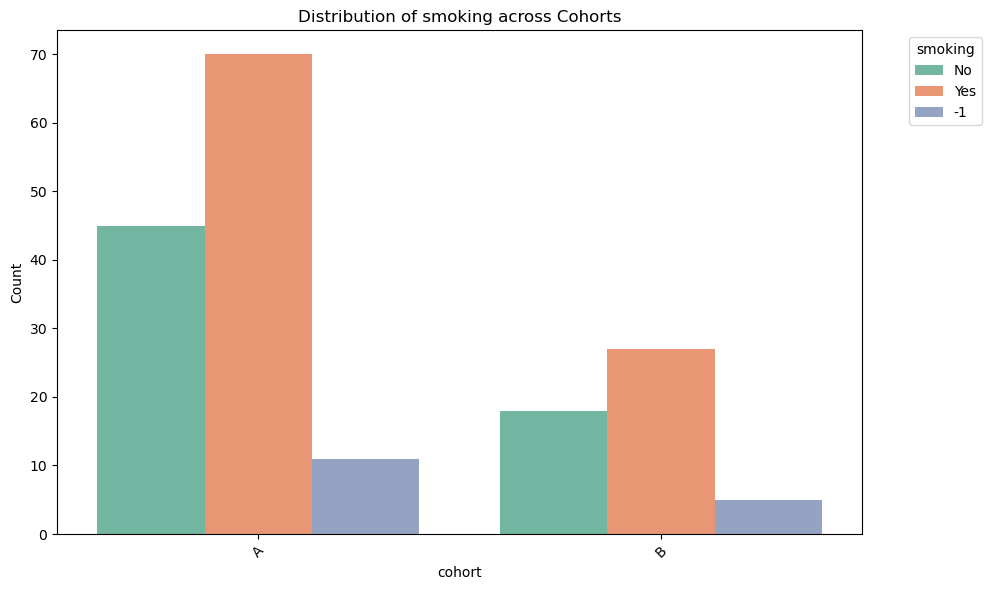

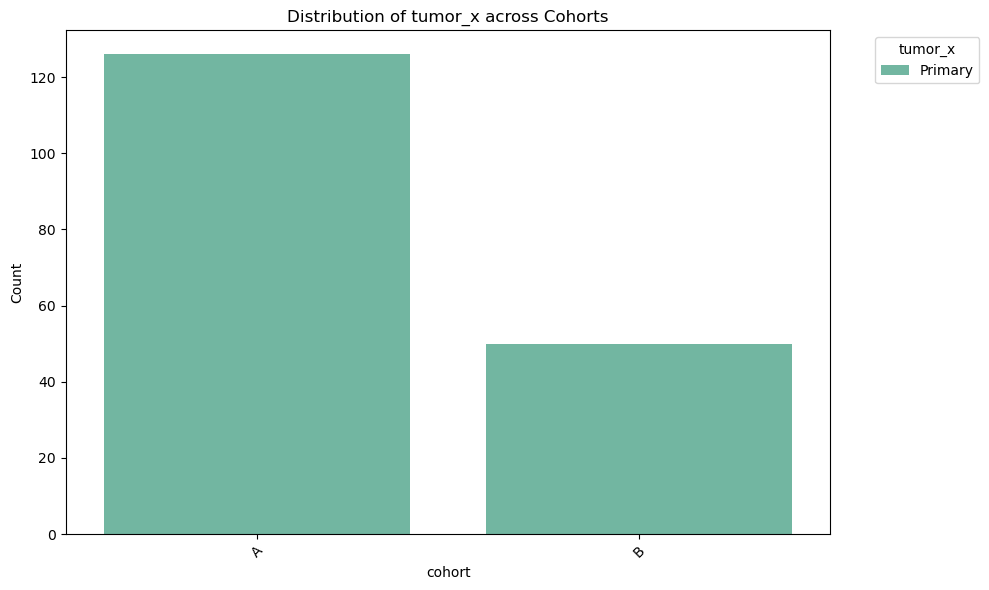

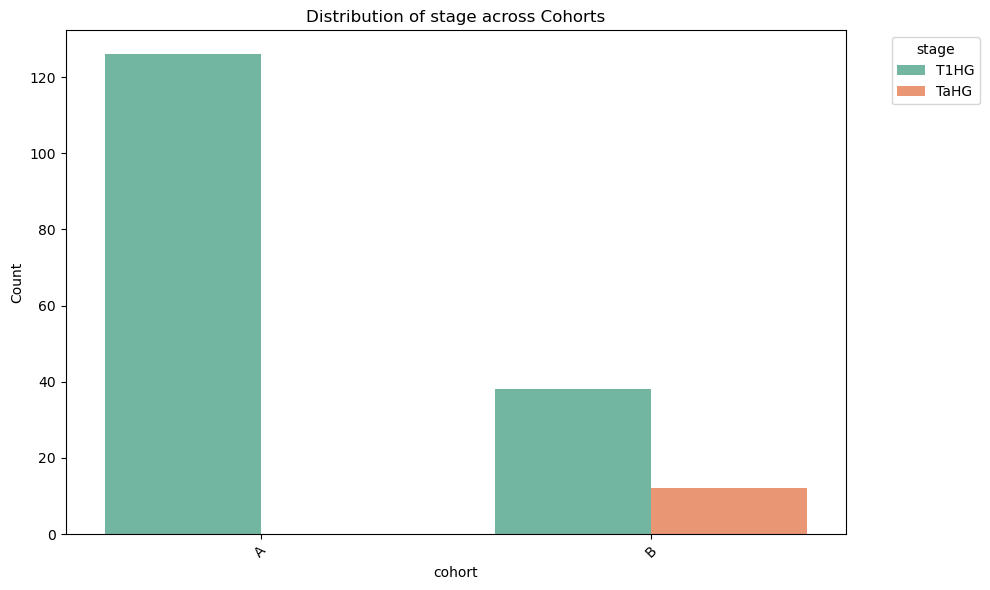

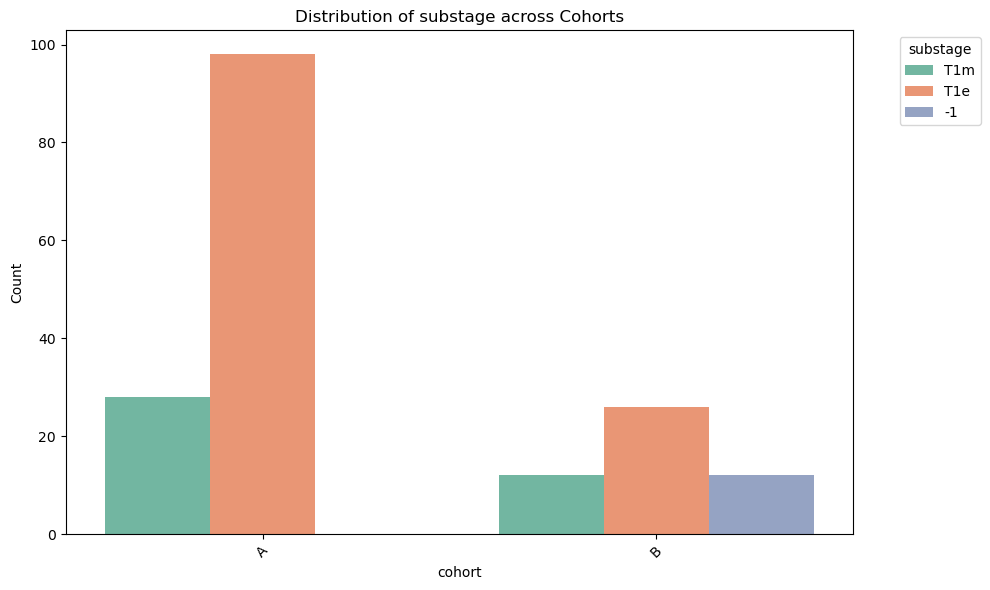

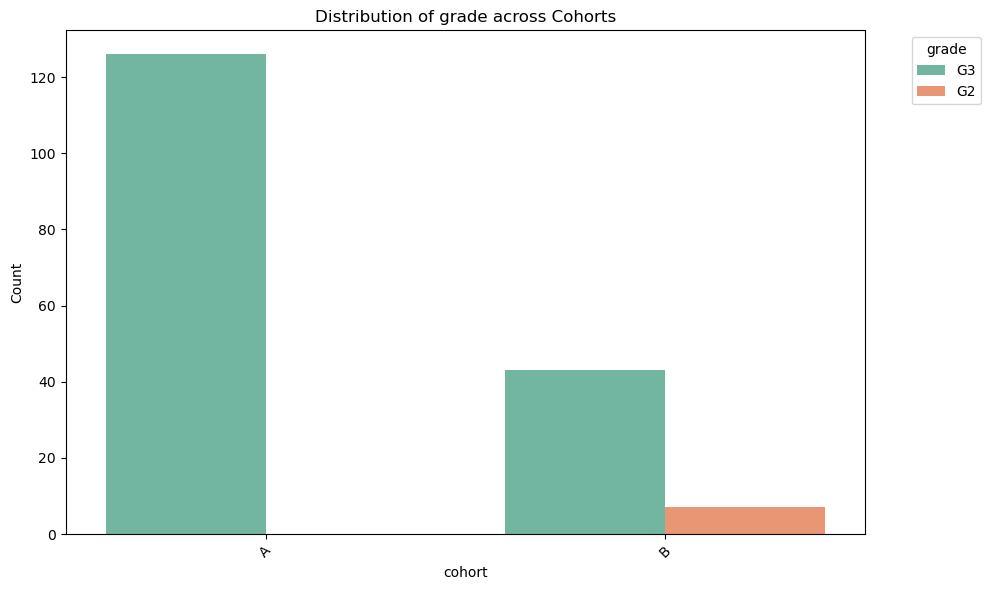

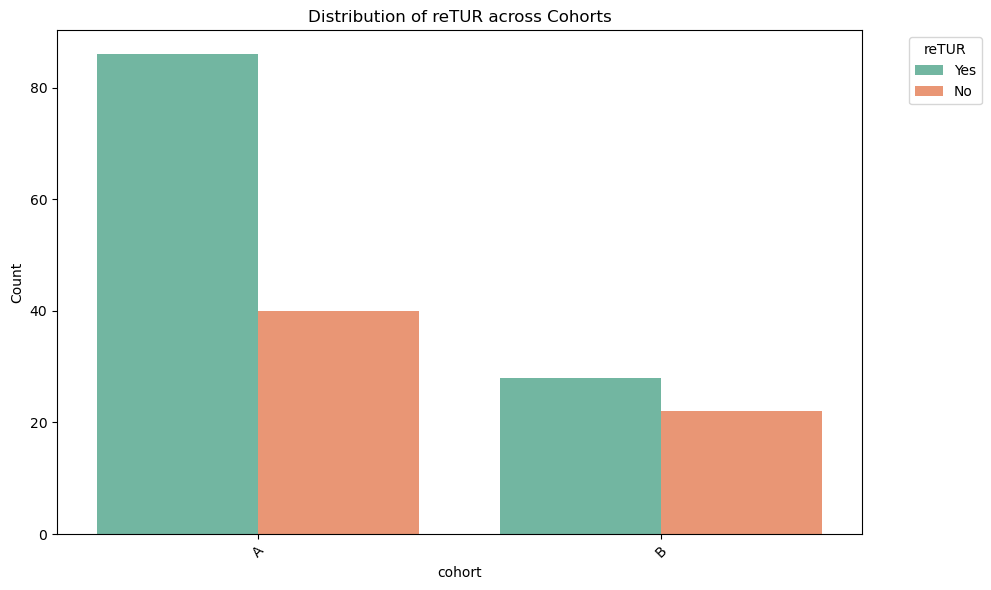

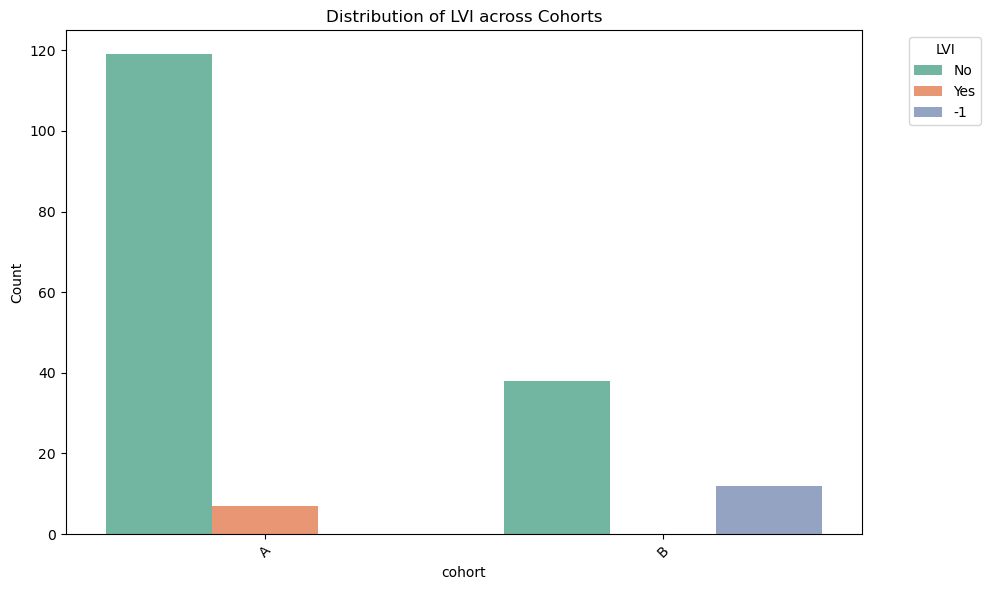

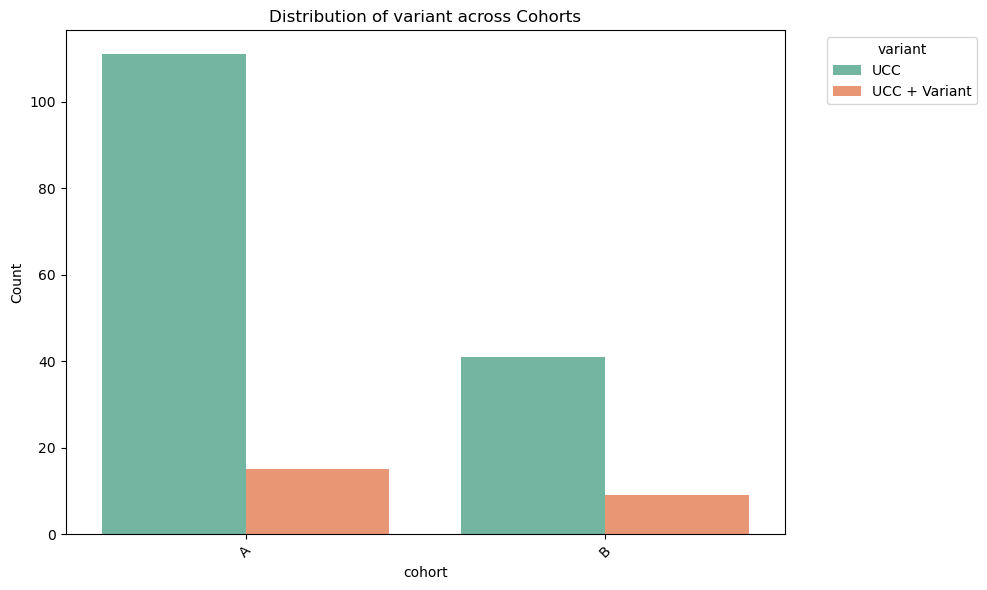

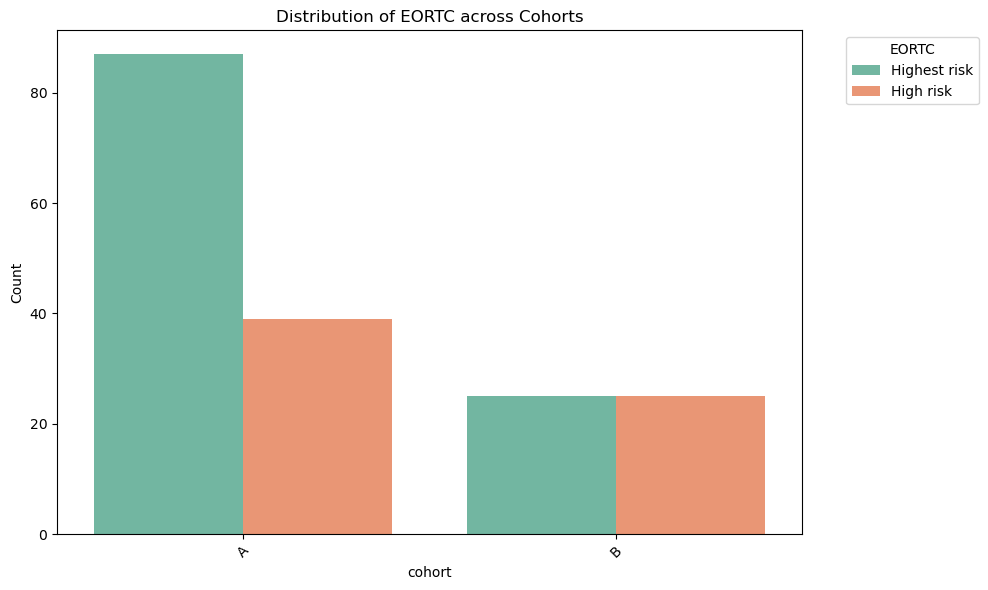

/var/folders/zl/l0prjwwn0db0fm9nhs69bxgh0000gn/T/ipykernel_47878/226588127.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='cohort', y=col, palette='Set2')


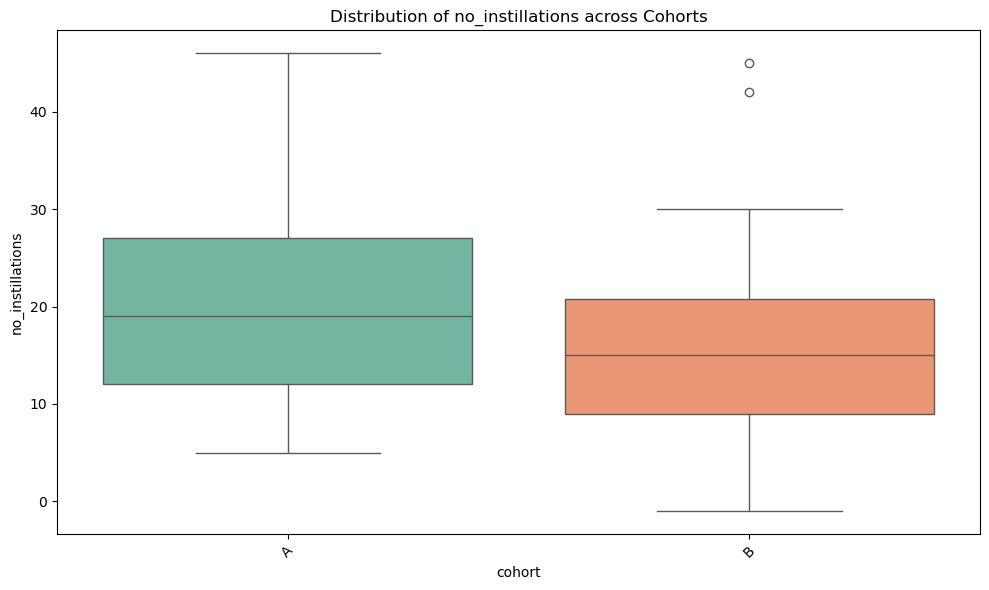

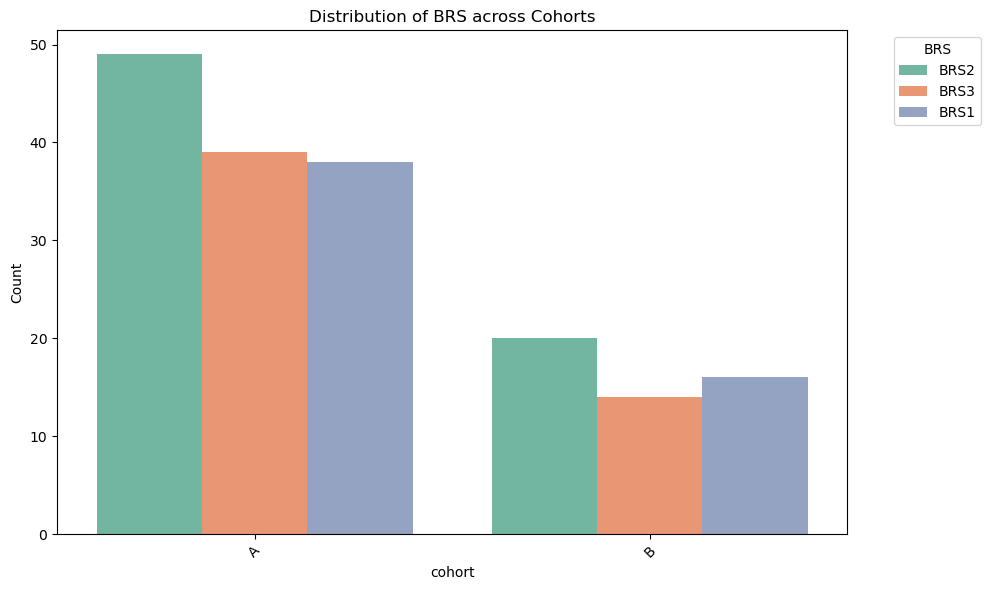

/var/folders/zl/l0prjwwn0db0fm9nhs69bxgh0000gn/T/ipykernel_47878/226588127.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='cohort', y=col, palette='Set2')


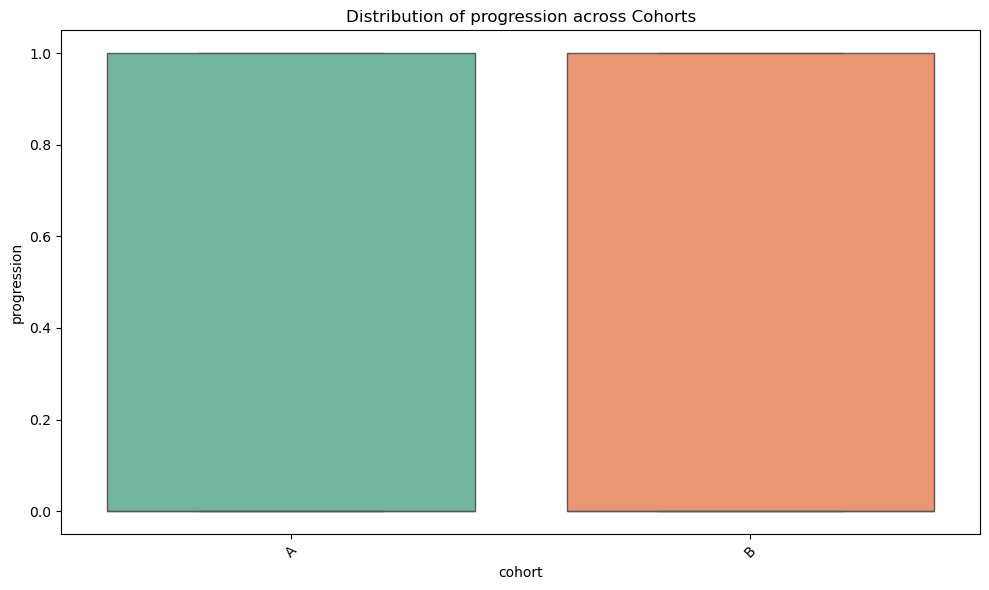

/var/folders/zl/l0prjwwn0db0fm9nhs69bxgh0000gn/T/ipykernel_47878/226588127.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='cohort', y=col, palette='Set2')


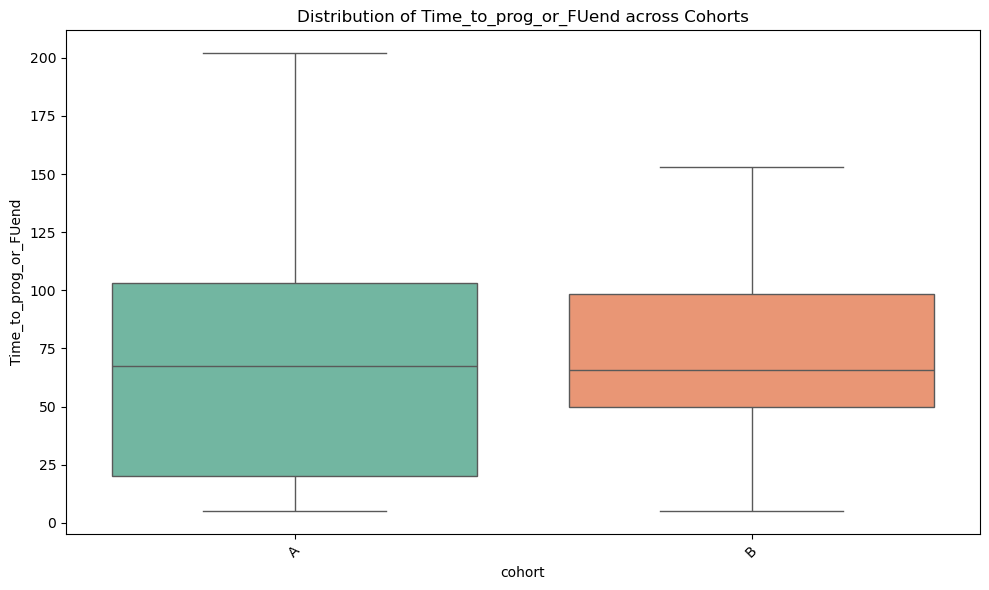

/var/folders/zl/l0prjwwn0db0fm9nhs69bxgh0000gn/T/ipykernel_47878/226588127.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


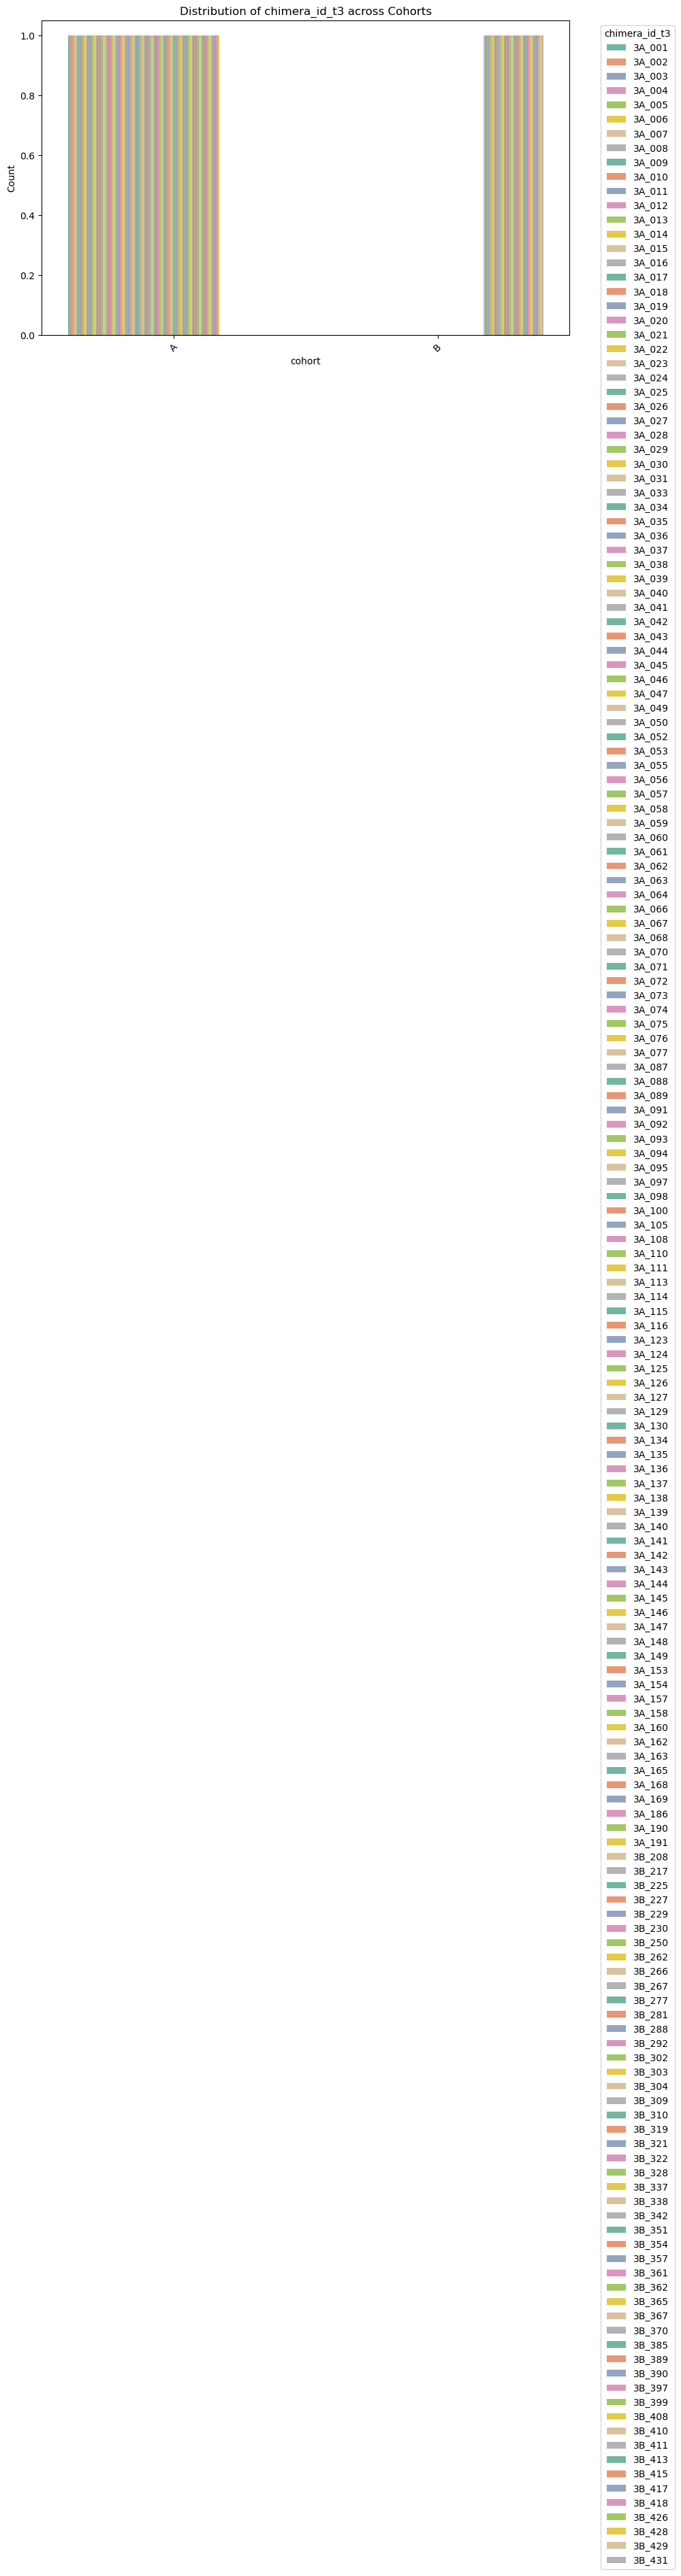

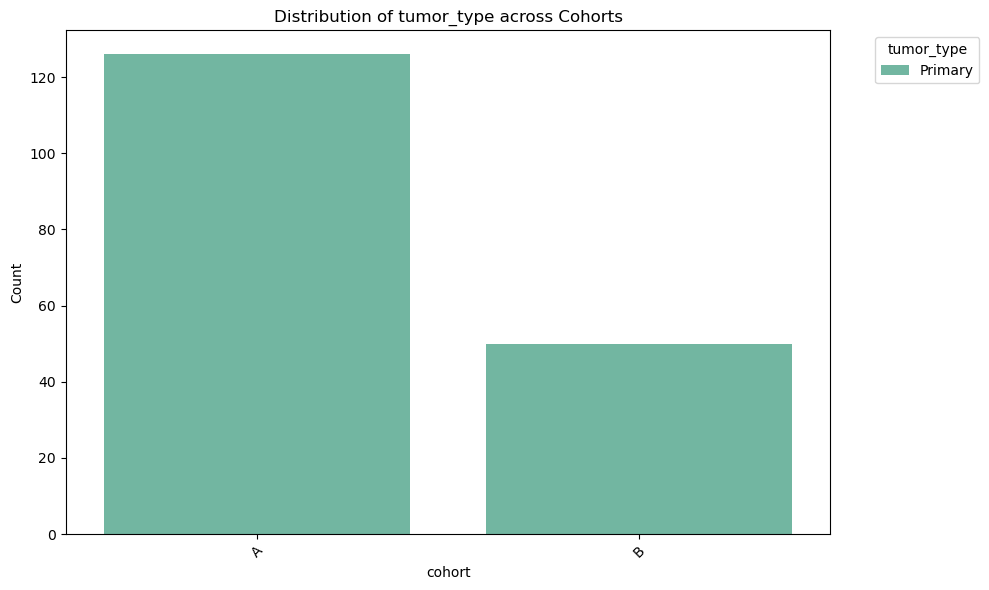

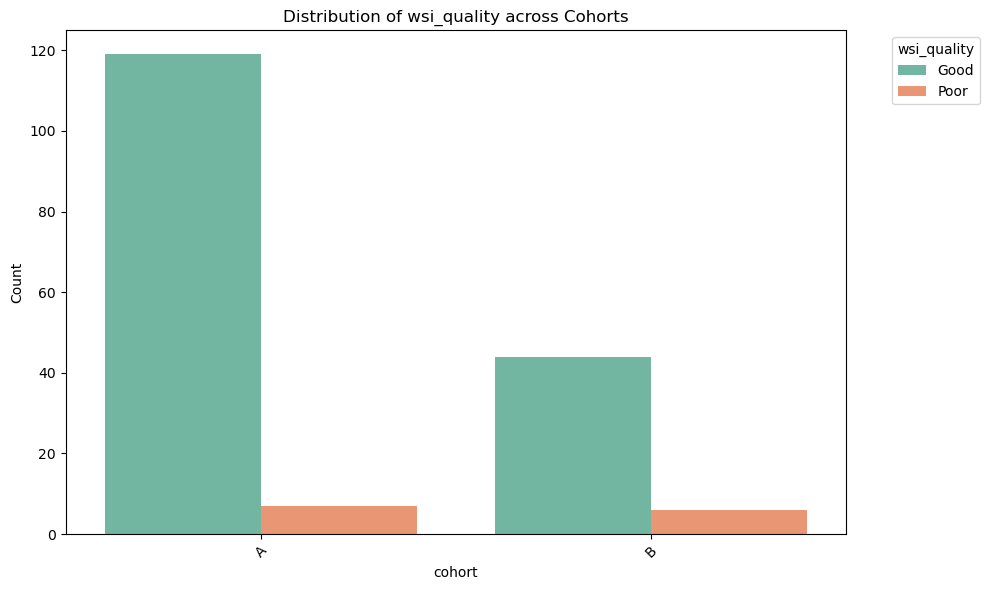

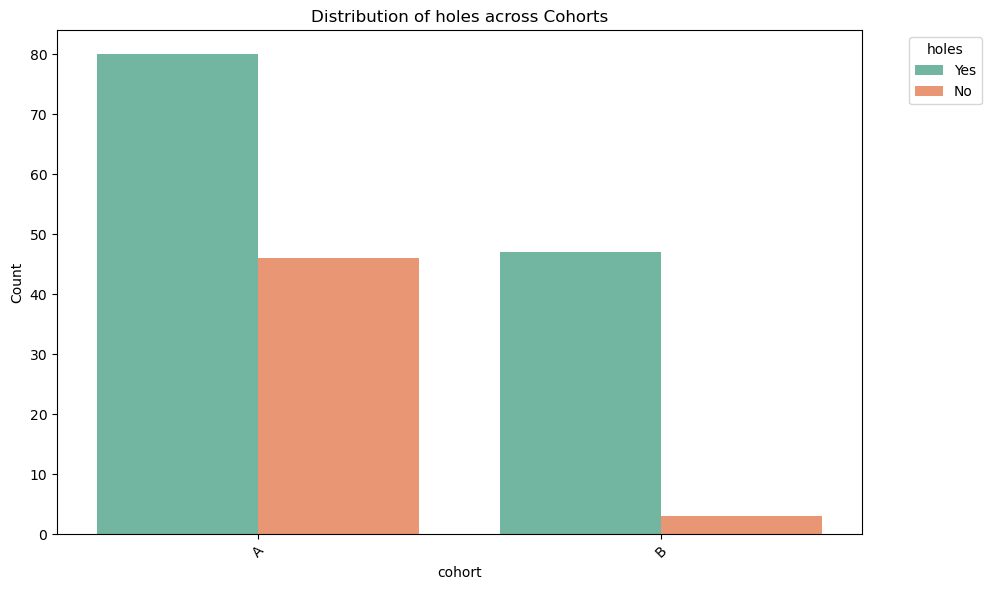

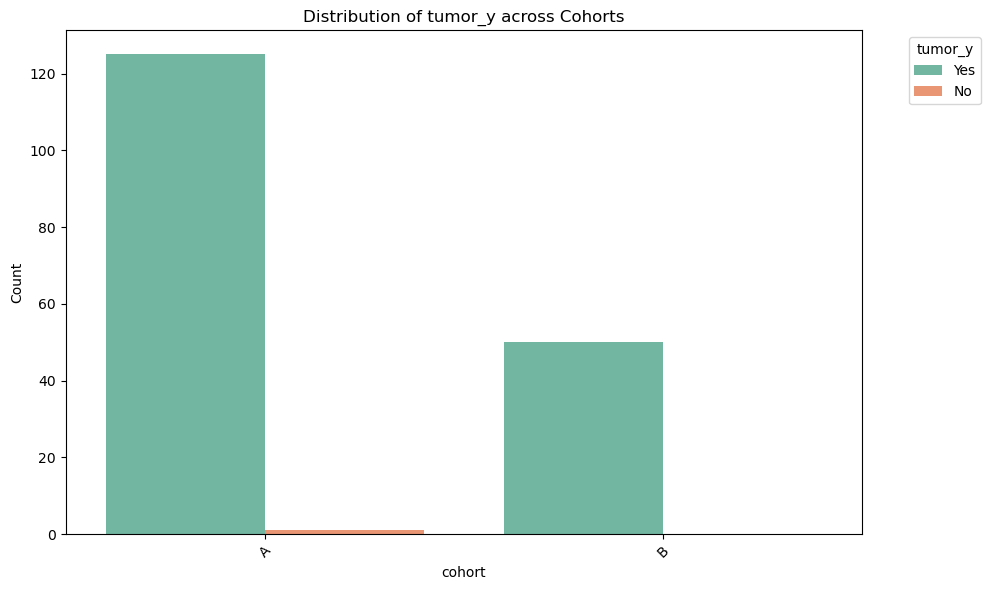

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Columns to plot (exclude 'cohort')
columns_to_plot = [c for c in df_merged.columns if c != 'cohort']

for col in columns_to_plot:
    plt.figure(figsize=(10,6))
    
    if df_merged[col].dtype == 'object' or df_merged[col].dtype.name == 'category':
        # Categorical: countplot
        sns.countplot(data=df_merged, x='cohort', hue=col, palette='Set2')
        plt.ylabel('Count')
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f'Distribution of {col} across Cohorts')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        # Numeric: boxplot
        sns.boxplot(data=df_merged, x='cohort', y=col, palette='Set2')
        plt.title(f'Distribution of {col} across Cohorts')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
